<a href="https://colab.research.google.com/github/11abdellah11/Image_captioning/blob/main/img_to_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro


In this notebook, we will explore the application of a visual attention mechanism to generate captions from images. Additionally, we will delve into the training and prediction of a text generation model.

# Setting Up Required Dependencies

In [ ]:
import time
from textwrap import wrap # - The textwrap module can be used for wrapping and formatting of plain text - adjust the line breaks in the input paragraph
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_datasets as tfds # we will use coco_captions dataset
import tensorflow_hub as hub # repository of trained machine learning models ready for fine-tuning and deployable anywhere.
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,  # In LSTM used to manage longue sequential data
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

# Getting the Dataset Ready for Modeling

we will use [InceptionResNetV2](https://keras.io/api/applications/inceptionresnetv2/)



- InceptionResNetV2 takes (299, 299, 3) image as inputs and return features in (8, 8, 1536) shape

In [ ]:
# FINE TUNING PARAMTERS
VOCAB_SIZE = 15000  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 [==============================] - 2s 0us/step


In [ ]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/" # the dataset is stored in a public gcs bucket in central-us1
BUFFER_SIZE = 1000

def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}

training_set = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)
training_set = training_set.map(get_image_label, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE)
training_set = training_set.prefetch(buffer_size=tf.data.AUTOTUNE)

# Visualisation

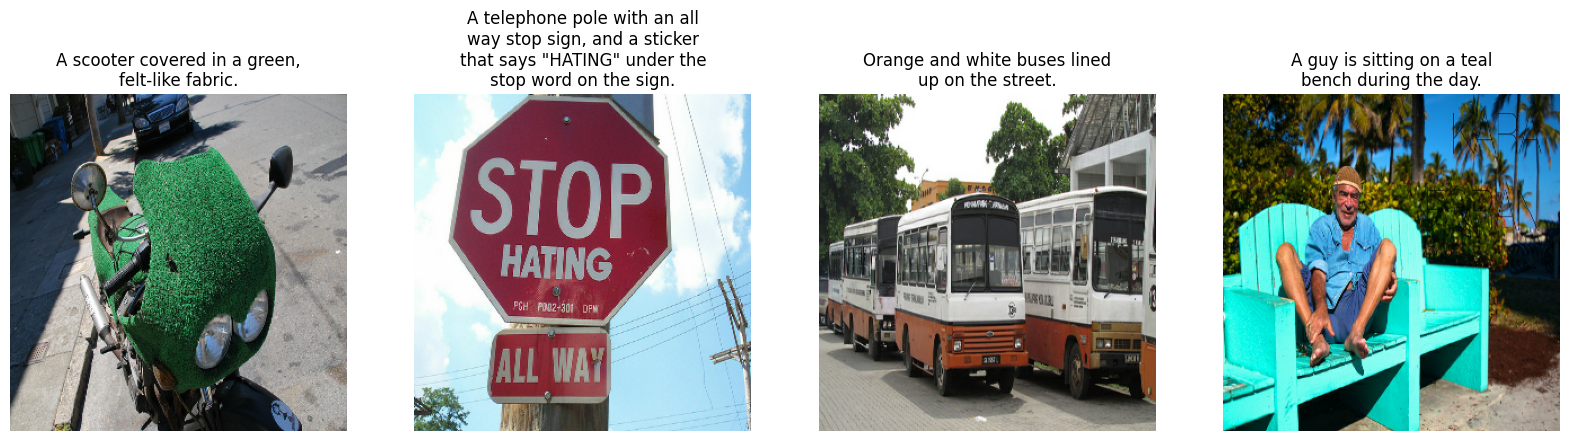

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(20,5))
for idx, data in enumerate(training_set.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

# Text preprocessing

We will tokenize the start and the end of the sentence to train the model how to create a caption < start  >/< end >

In [ ]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join([start, data["caption"], end], separator=" ")
    return data


training_set = training_set.map(add_start_end_token)

In [ ]:
training_set

<_MapDataset element_spec={'image_tensor': TensorSpec(shape=(299, 299, 3), dtype=tf.float32, name=None), 'caption': TensorSpec(shape=(), dtype=tf.string, name=None)}>

# Caption Preprocessing and Tokenization

- Using [TextVectorization](@https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer we will transform texts caption into integer sequences by mapping each word to its index in the vocabulary table

In [ ]:
max_caption_length = 64 # for the used dataset this number is sufficient as a length of caption token


def standardize(inputs):
  inputs = tf.strings.lower(inputs)

  return tf.strings.regex_replace(inputs,r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", "") #we will the special strings by a space ""


tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=max_caption_length,
)

tokenizer.adapt(training_set.map(lambda x: x["caption"]))

In [ ]:
tokenizer(['<start> this is a dog <end>']) # tokenizing a sentence

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 165,  11,   2,  47,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [ ]:


sample_captions = []
for d in training_set.take(5): # extract the first five data
    sample_captions.append(d["caption"].numpy())



In [ ]:
sample_captions

[b'<start> A man sitting in front of piles of ripe bananas. <end>',
 b'<start> White tennis outfit on a girl swinging with a tennis racket.  <end>',
 b'<start> A man prepares to hit a tennis ball. <end>',
 b'<start> a black white and gray cat and a black trash can <end>',
 b'<start> Elderly male citizen conversing with lady carrying blue/white umbrella <end>']

In [ ]:
tokenizer(sample_captions[0])

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([   3,    2,   12,   14,    8,   38,    5, 1542,    5,  752,  218,
          4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])>

In [ ]:
tokenizer(['<end>'])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

* We will use the StrinLookup layer to convert from a word to token and vice-versa

In [ ]:
# TOKEN to WORD
# n = 9
# p = tokenizer.get_vocabulary()[n]
# print(p)


# Lookup table: Word TO Index
word_to_index = StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())

# Lookup table: Index TO Word
index_to_word = StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

In [ ]:
BATCH_SIZE = 32
# create a tf dataset of image tensors, captions,

def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return (img_tensor, caption), target


batched_ds = (training_set.map(create_ds_fn).batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
batched_ds

<_PrefetchDataset element_spec=((TensorSpec(shape=(32, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, None), dtype=tf.int64, name=None)), TensorSpec(shape=(32, None), dtype=tf.int64, name=None))>

In [ ]:
for (img, caption), label in batched_ds.take(1):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3  986 1447   10  340  606   24  283   13  569    4    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
tf.Tensor(
[ 986 1447   10  340  606   24  283   13  569    4    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)


In [ ]:


FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)



In [ ]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55123680 (210.28 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


Caption decoder

In [ ]:
MAX_CAPTION_LEN = 64

In [ ]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = Attention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)